Import

In [7]:
%env "WANDB_NOTEBOOK_NAME" "grd-main"
CUDA_LAUNCH_BLOCKING="1"

import os 
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

import numpy as np
import random
from functools import partial

import torch
import torch.nn as nn

from predictive_model_gpu import make_fc
from greedy_coverage_gpu import set_func, marginal_vec, greedy
from greedy_submodular_new import GreedyOptimizer 

import seaborn as sns
import matplotlib.pyplot as plt

from numba import jit
import wandb

env: "WANDB_NOTEBOOK_NAME"="grd-main"
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
beta = 1                                        #Parameter of greedy optimizer, default 1
sample_size = 20                                #Parameter of greedy optimizer, default 10
eps = 0.2                                       #Parameter of greedy optimizer, default 0.1
k = 20                                          #Parameter of greedy optimizer, default 5

num_epochs = 20         
batch_size = 1
learning_rate = 5e-4
momentum = 0.8

num_layers = 2
activation = 'relu'
hidden_sizes = [150]
dropout = 0.15
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.uniform_(.0, .01)

N_INFLUENCERS = 500
N_TARGETS = 500
N_FEATURES = 29
N_INSTANCES = 10 
N_TRAIN = int(0.8 * N_INSTANCES)
instance_path = "instances_weibo/05-05-embedding_labels/"

q1, q2, q3 = 0.2, 0.5, 0.8 #quantiles for ground_truth probabilities
low_p, med_p, high_p = 0.2, 0.5, 1 #buckets for ground_truth probabilities


WandB config

In [9]:
#wandb config
config = {
    #instances parameters
    "N_INFLUENCERS": N_INFLUENCERS,
    "N_TARGETS": N_TARGETS,
    "N_FEATURES":N_FEATURES,
    "N_INSTANCES":N_INSTANCES,
    "instance_path" : instance_path,
    
    #labels parameters
    "(q1, q2, q3)" : (q1, q2, q3),
    '(low_p, med_p, high_p)' : (low_p, med_p, high_p),

    #greedy parameters
    "beta" : beta,               
    "sample_size" : sample_size,      
    "eps" : eps,              
    "k" : k,             

    #ML parameters
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "momentum": momentum,
    "batch_size": batch_size,
    "num_layers" : num_layers,
    "activation" : activation,
    "hidden_sizes" : hidden_sizes,
    "dropout" : dropout, }

wandb.init(project="influence-maximization", entity="mario-michelessa", config=config)

Device

In [10]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
wandb.config.update({"device":device})
torch.cuda.empty_cache()
#Additional Info when using cuda
if device.type == 'cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
GeForce GTX 1050 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Preprocessing

Instances definition

In [30]:

def transform_Y(Y) : 
    Yc = np.copy(Y)
    #return np.minimum(100 * Y_train, np.ones((N_TRAIN, N_INFLUENCERS, N_TARGETS)))
    t1 = np.quantile(Y[Y>0], q1) # weak probability
    t2 = np.quantile(Y[Y>0], q2) # medium probability
    t3 = np.quantile(Y[Y>0], q3) # high probability
    Y[Yc>t1] = low_p
    Y[Yc>t2] = med_p
    Y[Yc>t3] = high_p
    return Y  

def transform_Yemb(Y) :
    return Y / np.max(Y)

@jit
def create_train_test(train_id):
    """
    input : train_id, test_id = partition of range(N_INSTANCES)
    returns X_train, Y_train, X_test, Y_test
    """

    X_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    X_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS, N_FEATURES))
    Y_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))
    
    Yemb_train = np.zeros((N_TRAIN, N_INFLUENCERS, N_TARGETS))
    Yemb_test = np.zeros((N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))
    
    c_train, c_test = 0, 0
    for instance in range(N_INSTANCES) :
        XY = np.load(instance_path + f"{instance}.npz")['arr_0']
        if instance in train_id :

            #when no embedding labels
            # X_train[c_train] = XY[:,:,:-1]
            # Y_train[c_train] = XY[:,:,-1]
            X_train[c_train] = XY[:,:,:-2]
            Y_train[c_train] = XY[:,:,-2]
            Yemb_train[c_train] = XY[:,:,-1]
            c_train += 1
        
        else : 
            # X_test[c_test] = XY[:,:,:-1]
            # Y_test[c_test] = XY[:,:,-1]
            X_test[c_test] = XY[:,:,:-2]
            Y_test[c_test] = XY[:,:,-2]
            Yemb_test[c_test] = XY[:,:,-1]
            c_test += 1
    
    #Cheating line
    #X_train[:,:,:,9] = Y_train * 2
    
    Y_train = transform_Y(Y_train)
    Y_test = transform_Y(Y_test)

    X_train = torch.from_numpy(X_train).float()
    Y_train = torch.from_numpy(Y_train).float()
    Yemb_train = torch.from_numpy(Yemb_train).float()

    X_test = torch.from_numpy(X_test).float()
    Y_test = torch.from_numpy(Y_test).float()
    Yemb_test = torch.from_numpy(Yemb_test).float()

    # test on random dense labels
    #Y_train = torch.bernoulli(torch.zeros(Y_train.size()),0.1)
    #Y_test = torch.bernoulli(torch.zeros(Y_test.size()),0.1)
    
    # Y_train = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    # Y_test = torch.from_numpy(np.random.uniform(low=0, high=1, size=(N_INSTANCES - N_TRAIN, N_INFLUENCERS, N_TARGETS))).float()
    
    
    return X_train, Y_train, X_test, Y_test, Yemb_train, Yemb_test

Dataset

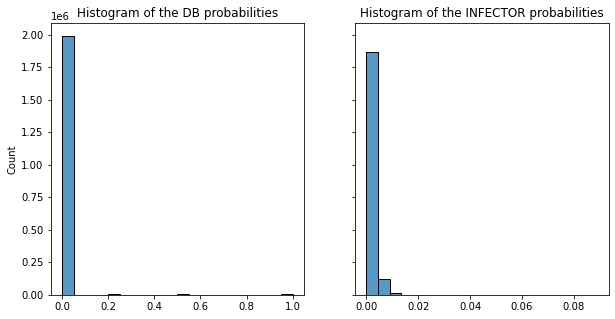

In [40]:
w = np.ones(N_TARGETS, dtype=np.float32)
train_id = random.sample(list(range(N_INSTANCES)), N_TRAIN)

#X_train, Yemb_train, X_test, Yemb_test, Y_train, Y_test = create_train_test(train_id)
X_train, Y_train, X_test, Y_test, Yemb_train, Yemb_test = create_train_test(train_id)
dataset = torch.utils.data.TensorDataset(X_train, Y_train) 

fig, ax = plt.subplots(1,2, figsize = (10,5), sharey=True)
sns.histplot(Y_train.flatten(), ax = ax[0], bins=20)
ax[0].set_title("Histogram of the DB probabilities")
sns.histplot(Yemb_train.flatten(), ax = ax[1], bins=20)
ax[1].set_title("Histogram of the INFECTOR probabilities")
plt.show()

Print training

In [41]:
def print_training(loss, train, test, title = "") : 

    fig, ax = plt.subplots(1,2, figsize = (10,5))
    plt.suptitle(title)
    ax[0].plot(loss)
    ax[0].set_title('Learning curve')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')

    ax[1].plot(train, label="train_scores")
    ax[1].plot(test, label="test_scores")
    ax[1].set_title('Quality')
    ax[1].set_ylabel('influence')
    ax[1].set_xlabel('epoch')
    ax[1].legend()
    plt.show()

    

Evaluation function

In [42]:
def dni(seeds, Y) : 
    """
    estimates the number of Different Nodes Infected given a seed set and a DATA-BASED label. 
        If a data-based label of (u,v) is positive, it means that v appears in at least one cascade of u
    for each column(target) if one of the labels is >0 then it appears in a cascade provoqued by one of the seeds
    """
    return (Y[seeds,:].sum(dim=0) > 0).sum().item() 

def eval_dni(net, X, Y):
    """
    input : X[instances, nI, nT, nF], Y[instances, nI, nT]
    estimates number of different nodes infected based on the cascades
    """
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([  dni(    greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1]    ,Y[i]) for i in range(X.shape[0])])
    return float(result) #float is here to delete the gradient if there is a torch gradient

def eval_grd(net, X, Y):
    """
    estimates expectation of dni in the bipartite graph: sum(1-prod(1-p_uv))
    """
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([    set_func(   greedy(k, net(X[i,:,:,:]).view_as(Y_train[0]), w)[1], Y[i, :, :], w) for i in range(X.shape[0])])
    return float(result)

def eval_loss(net, X, Y, loss):
    """
    validation loss
    """
    X = X.to(device)
    Y = Y.to(device)
    result = np.mean([np.sum( ( net(X[i,:,:,:]).view_as(Y[0]) - Y[i, :, :] ).cpu().detach().numpy() **2. ) for i in range(X.shape[0])])
    return float(result)

def eval_rnd(X, Y):
    """
    Randomly selects seeds and computes influence
    """
    Y = Y.to(device)
    sol = random.sample(range(N_INFLUENCERS),k)   
    return np.mean([set_func(sol, Y[i,:,:], w) for i in range(X.shape[0])])

Random

In [27]:
rd_score_xtrain = np.mean([eval_rnd(X_train, Y_train) for _ in range(100)])
rd_score_xtest = np.mean([eval_rnd(X_test, Y_test) for _ in range(100)])
print(f"Average random score X_train : {rd_score_xtrain}")
print(f"Average random score X_test : {rd_score_xtest}")

wandb.log({"rd_score_xtrain" : rd_score_xtrain})
wandb.log({"rd_score_xtest" : rd_score_xtest})

Average random score X_train : 19.55673384428024
Average random score X_test : 19.574460992813112


### Decision focused

Model definition

In [28]:
train_scores_df = []
test_scores_df  = []
train_dni_df = []
test_dni_df  = []
loss_df = []
seeds_df = []

net_df = make_fc(N_FEATURES, num_layers, activation, hidden_sizes, dropout)
net_df.apply(init_weights)
net_df = net_df.to(device)
#net = net.half()
net_df.modules

<bound method Module.modules of Sequential(
  (0): Linear(in_features=29, out_features=150, bias=True)
  (1): ReLU()
  (2): Linear(in_features=150, out_features=1, bias=True)
  (3): Hardtanh(min_val=0, max_val=1.0)
  (4): Dropout(p=0.15, inplace=False)
)>

Training

In [29]:

print("epoch | loss | train_score | test_score | train_dni | test_dni")

optimizer = torch.optim.Adam(net_df.parameters(), lr = learning_rate, betas = (momentum, 0.999))
marginal_vec_pred = partial(marginal_vec, w = w)

for epoch in range(40):
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, )
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X = X.to(device)
            P = P.to(device)
            
            true_set_func = partial(set_func, P = P, w = w)
            pred = net_df(X).view_as(P)                
            fn = GreedyOptimizer.apply
            loss -= fn(pred, true_set_func, marginal_vec_pred, N_INFLUENCERS,  k,  eps, sample_size, beta)
            del(X)
            del(P)
        
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_score = eval_grd(net_df, X_train, Y_train)
    test_score  = eval_grd(net_df, X_test, Y_test)
    
    train_dni = eval_dni(net_df, X_train, Y_train)
    test_dni  = eval_dni(net_df, X_test, Y_test)

    loss_df.append(loss.item())

    wandb.log({ "epoch_df" : len(loss_df), 
                "loss_df" : loss.item(), 
                "train_score_df" : train_score, 
                "test_score_df" : test_score,
                "train_dni_df" : train_dni, 
                "test_dni_df" : test_dni},)
    
    print(f"{len(loss_df)} | {loss.item()} | {train_score} | {test_score} | {train_dni} | {test_dni}")

    train_scores_df.append(train_score)
    test_scores_df.append(test_score)
    train_dni_df.append(train_dni)
    test_dni_df.append(test_dni)


epoch | loss | train_score | test_score | train_dni | test_dni
1 | -19.568111419677734 | 19.569860458374023 | 19.597546577453613 | 484.875 | 480.5
2 | -19.6102237701416 | 19.611736059188843 | 19.644275665283203 | 486.25 | 487.0
3 | -19.56249237060547 | 0.9996202737092972 | 1.0029963850975037 | 465.375 | 434.5
4 | -19.562265396118164 | 0.9996202737092972 | 1.0029963850975037 | 465.375 | 434.5
5 | -19.54353904724121 | 0.9996202737092972 | 1.0029963850975037 | 465.375 | 434.5
6 | -19.55843162536621 | 0.9996202737092972 | 1.0029963850975037 | 465.375 | 434.5
7 | -19.554502487182617 | 0.9996202737092972 | 1.0029963850975037 | 465.375 | 434.5
8 | -19.565561294555664 | 0.9996202737092972 | 1.0029963850975037 | 465.375 | 434.5


KeyboardInterrupt: 

Plot Curve

In [ ]:
print_training(loss_df, train_scores_df, test_scores_df, "Training of Decision based model embeddings")

### 2 Stage

Model definiton

In [67]:

train_scores_2s = []
test_scores_2s  = []
train_dni_2s = []
test_dni_2s  = []
loss_2s = []
val_loss_2s = []

net_2s = make_fc(N_FEATURES, num_layers, activation, hidden_sizes, dropout=0.15)
net_2s.apply(init_weights)
net_2s = net_2s.to(device)
print(net_2s.modules)

loss_fn = nn.MSELoss()
def loss_unbalanced(pred, P) : 
    """
    to counter the sparsity of the data, when the model predicts lower probabilities than the ground truth, the loss is higher
    """
    # neg = pred < P
    # pos = pred > P
    # return 100 * loss_fn(pred[neg], P[neg]) + loss_fn(pred[pos],P[pos])
    phi = 1.
    return torch.sum(torch.exp(phi * (P - pred)) - phi * (P-pred) - 1)

optimizer = torch.optim.Adam(net_2s.parameters(), lr = 1e-3)
#optimizer = torch.optim.SGD(net_2s.parameters(), lr = 1e-3)

<bound method Module.modules of Sequential(
  (0): Linear(in_features=29, out_features=150, bias=True)
  (1): ReLU()
  (2): Linear(in_features=150, out_features=1, bias=True)
  (3): Hardtanh(min_val=0, max_val=1.0)
  (4): Dropout(p=0.15, inplace=False)
)>


Training

In [68]:

print("epoch | loss | val loss | train_score | test_score | train_dni | test_dni")

for epoch in range(10):
    data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, ) #shuffle=True 
    for X_batch, P_batch in data_loader:
        loss = 0 
        for X, P in zip(X_batch, P_batch):
            X, P = X.to(device), P.to(device)
            pred = net_2s(X).view_as(P)
            loss += loss_unbalanced(pred, P)
        loss = loss / batch_size
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net_2s.parameters(), 0.01)
        optimizer.step()

    val_loss = eval_loss(net_2s, X_test, Y_test, loss_fn)
    train_score = eval_grd(net_2s, X_train, Y_train)
    test_score  = eval_grd(net_2s, X_test, Y_test)
    train_dni = eval_dni(net_2s, X_train, Y_train)
    test_dni  = eval_dni(net_2s, X_test, Y_test)
    print(f"{len(loss_2s)} | {loss} | {val_loss} | {train_score} | {test_score} | {train_dni} | {test_dni}" )   

    train_scores_2s.append(train_score)
    test_scores_2s.append(test_score)     
    train_dni_2s.append(train_dni)
    test_dni_2s.append(test_dni)     
    val_loss_2s.append(val_loss)
    loss_2s.append(loss.item())

    wandb.log({ "epoch_2s" : len(loss_2s), 
                "loss_2s" : loss.item(), 
                "val_loss_2s" : val_loss,
                "train_score_2s" : train_score, 
                "test_score_2s" : test_score,
                "train_dni_2s" : train_dni, 
                "test_dni_2s" : test_dni})

epoch | loss | val loss | train_score | test_score | train_dni | test_dni
0 | 505.38311767578125 | 688.484375 | 8.175000071525574 | 10.75 | 16.875 | 15.5
1 | 309.21746826171875 | 452.295654296875 | 1.0624999403953552 | 4.25 | 3.25 | 5.0
2 | 309.21746826171875 | 452.295654296875 | 1.0624999403953552 | 4.25 | 3.25 | 5.0
3 | 309.21746826171875 | 452.295654296875 | 1.0624999403953552 | 4.25 | 3.25 | 5.0
4 | 309.21746826171875 | 452.295654296875 | 1.0624999403953552 | 4.25 | 3.25 | 5.0
5 | 309.21746826171875 | 452.295654296875 | 1.0624999403953552 | 4.25 | 3.25 | 5.0
6 | 309.21746826171875 | 452.295654296875 | 1.0624999403953552 | 4.25 | 3.25 | 5.0
7 | 309.21746826171875 | 452.295654296875 | 1.0624999403953552 | 4.25 | 3.25 | 5.0
8 | 309.21746826171875 | 452.295654296875 | 1.0624999403953552 | 4.25 | 3.25 | 5.0
9 | 309.21746826171875 | 452.295654296875 | 1.0624999403953552 | 4.25 | 3.25 | 5.0


Plot Curve

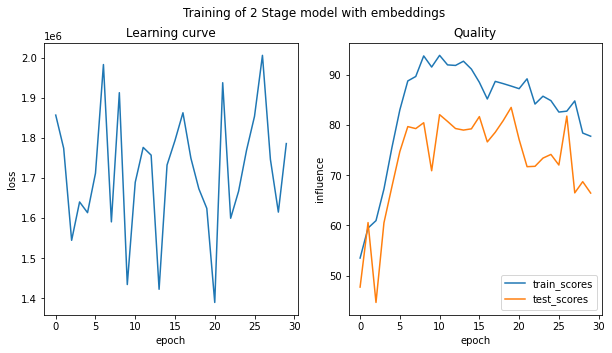

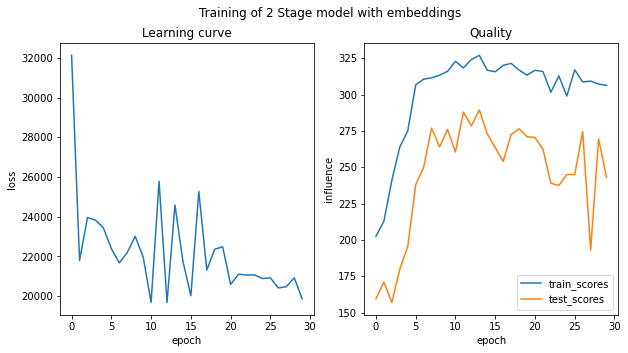

In [64]:
print_training(loss_2s, train_scores_2s, test_scores_2s,"Training of 2 Stage model with embeddings")
print_training(val_loss_2s, train_dni_2s, test_dni_2s,"Training of 2 Stage model with embeddings")

### Hyperparameter tuning

Sweep df

In [ ]:
sweep_config = {
  "program" : "grd_main",
  "name" : "sweep-df architecture 3 layers",

  "method" : "bayes",
  "metric":{
    "name": "test_score",
    "goal": "maximize",},

  "parameters" : {
    "layer1_size" : {"min" : 75, "max" : 200},
    "layer2_size" : {"min" : 75, "max" : 200} 
    }
  }

def train_df():
  with wandb.init(project="influence-maximization", entity="mario-michelessa") as run:
    config = wandb.config

    net_df = make_fc(N_FEATURES, num_layers, activation, [config["layer1_size"],config["layer2_size"]], dropout=0.15)
    net_df.apply(init_weights)
    net_df = net_df.to(device)
    
    optimizer = torch.optim.Adam(net_df.parameters(), lr = 5e-4, betas = (0.8, 0.999))
    marginal_vec_pred = partial(marginal_vec, w = w)

    for epoch in range(20):
      
      data_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, )
      for X_batch, P_batch in data_loader:
          loss = 0 
          for X, P in zip(X_batch, P_batch):
              X = X.to(device)
              P = P.to(device)
              true_set_func = partial(set_func, P = P, w = w)
              pred = net_df(X).view_as(P)                
              fn = GreedyOptimizer.apply
              loss -= fn(pred, true_set_func, marginal_vec_pred, N_INFLUENCERS,  k, 0.2, sample_size, beta)
          
          loss = loss / 1
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
      
      train_score = eval_grd(net_df, X_train, Y_train)
      test_score  = eval_grd(net_df, X_test, Y_test)

      wandb.log({"loss": loss})
      wandb.log({"train_score": train_score})
      wandb.log({"test_score": test_score})


In [ ]:
count = 20 # number of runs to execute
sweep_df = wandb.sweep(sweep_config)
wandb.agent(sweep_df, function=train_df, count=count)

Sweep 2 stage

In [ ]:
sweep_config = {
  "program" : "grd-main",
  "name" : "sweep-2s",

  "method" : "bayes",
  "metric":{
    "name": "loss",
    "goal": "minimize",},

  "parameters" : {
    "epochs" :            { "values" : [10] },
    "learning_rate" :     { "min": 0.00005, "max": 0.01 },
    "num_layers" :        {"values" : [3] },
    "layer1_size" :       {"values" : [50,100,150,200]}, 
    "layer2_size" :       {"values" : [50,100,150,200]}, 
    "dropout" : {"min" : 0.01, "max" : 0.5},
    }

  }

sweep_2s = wandb.sweep(sweep_config)

In [ ]:
def train_2s():
  with wandb.init(project="influence-maximization", entity="mario-michelessa") as run:
    config = wandb.config

    #X_train, Y_train, X_test, Y_test = create_train_test(train_id,config["q1"],config["q2"],config["q3"],config["low_p"],config["med_p"],config["high_p"])
    #dataset = torch.utils.data.TensorDataset(X_train, Y_train) 

    net_2s = make_fc(N_FEATURES, num_layers, activation, [config["layer1_size"],config["layer2_size"]], config["dropout"])
    net_2s.apply(init_weights)
    net_2s = net_2s.to(device)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(net_2s.parameters(), lr = learning_rate, betas=(0.8, 0.999))

    for epoch in range(num_epochs):
        data_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, ) #shuffle=True 
        for X_batch, P_batch in data_loader:
            loss = 0 
            for X, P in zip(X_batch, P_batch):
                X, P = X.to(device), P.to(device)
                pred = net_2s(X).view_as(P)
                loss += loss_fn(pred, P)
            loss = loss / batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_score = eval_grd(net_2s, X_train, Y_train)
        test_score  = eval_grd(net_2s, X_test, Y_test)

        wandb.log({"loss": loss})
        wandb.log({"train_score": train_score})
        wandb.log({"test_score": test_score})

count = 15 # number of runs to execute
wandb.agent(sweep_2s, function=train_2s, count=count,)


### Plots


Heatmap instances

NameError: name 'X_train' is not defined

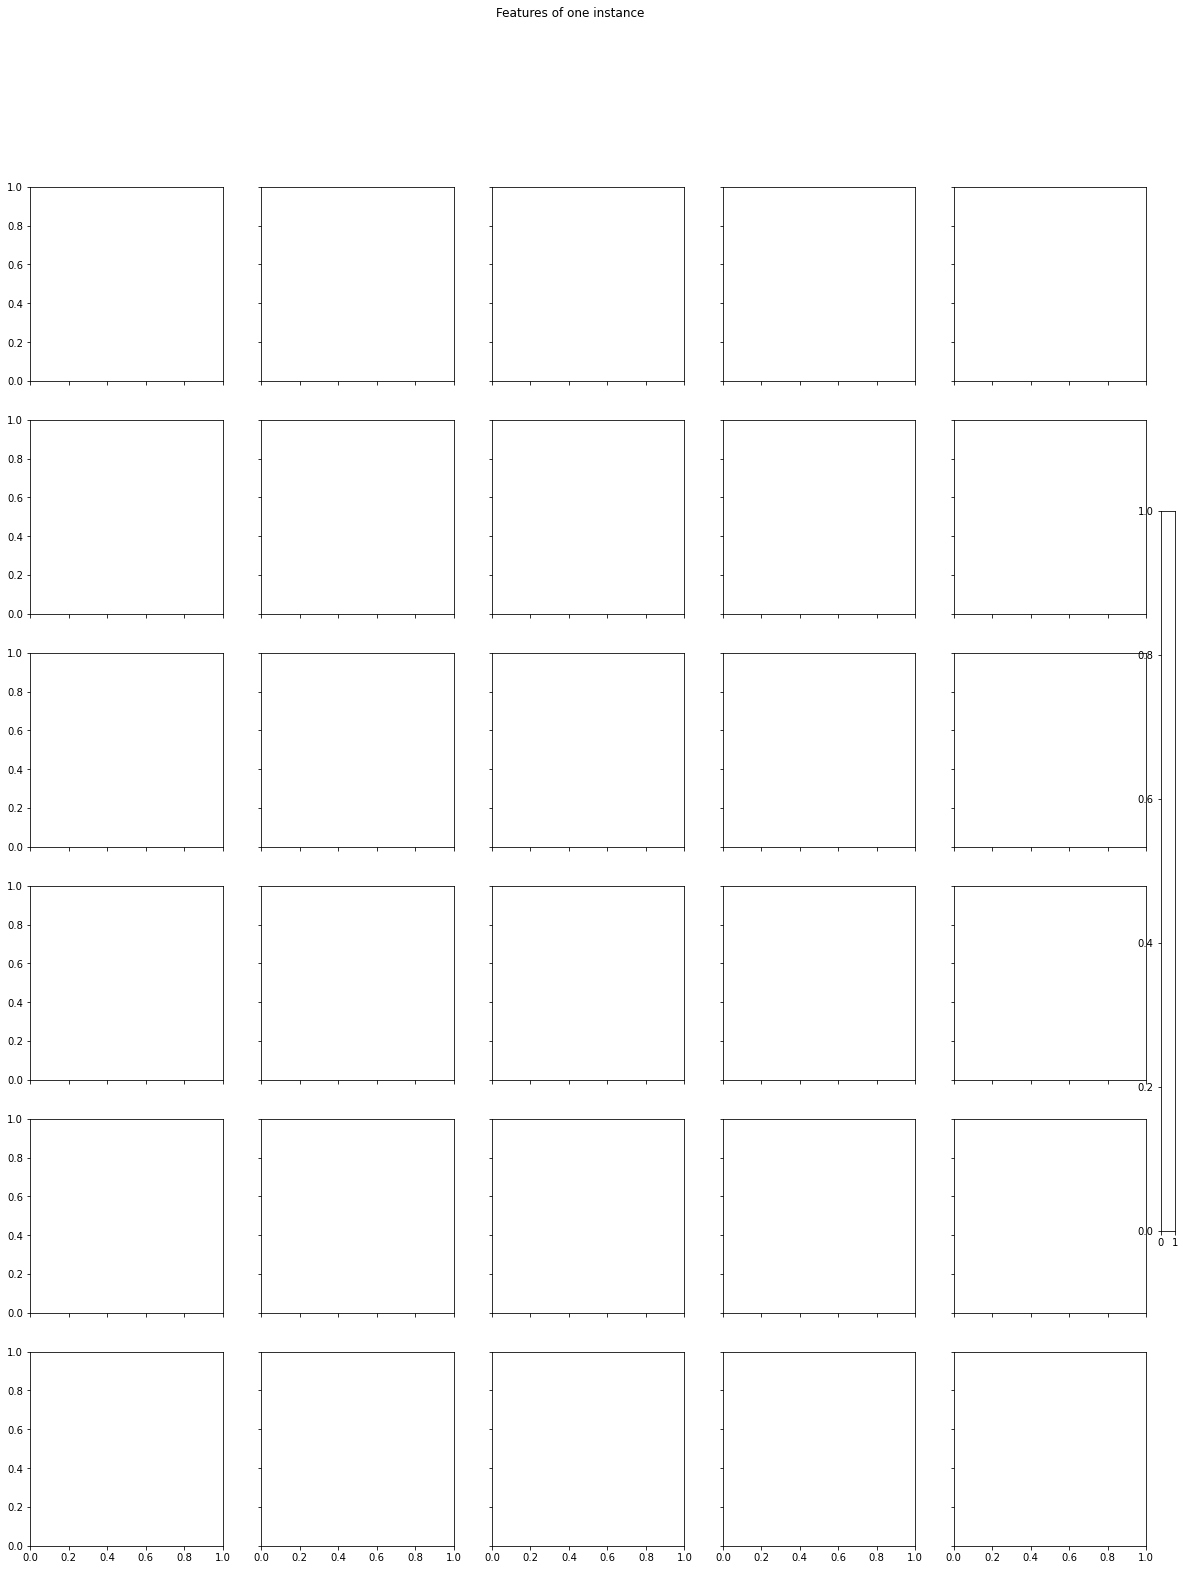

In [3]:
fig, axn = plt.subplots(6, 5, sharex=True, sharey=True, figsize = (20,25))
cbar_ax = fig.add_axes([.91, .3, .01, .4])
plt.suptitle("Features of one instance")

for i, ax in enumerate(axn.flat):
    if i > 28 : break
    sns.heatmap(X_train[1,:,:,i], ax=ax,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)

#### Plot of hidden layers weights

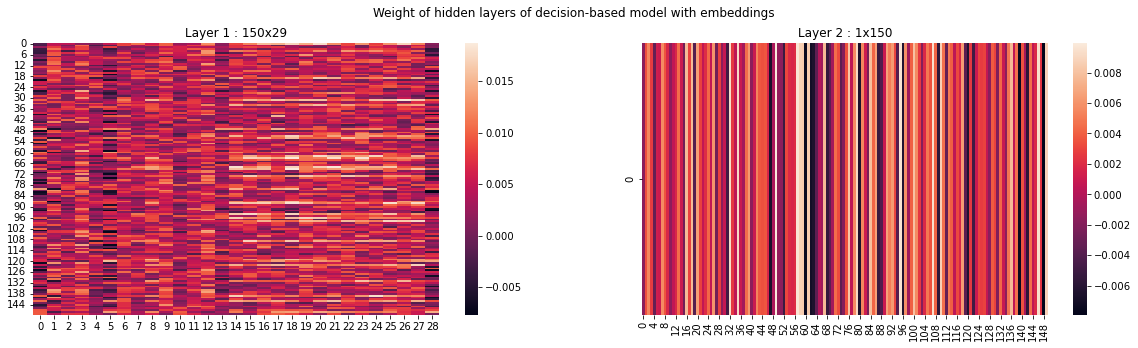

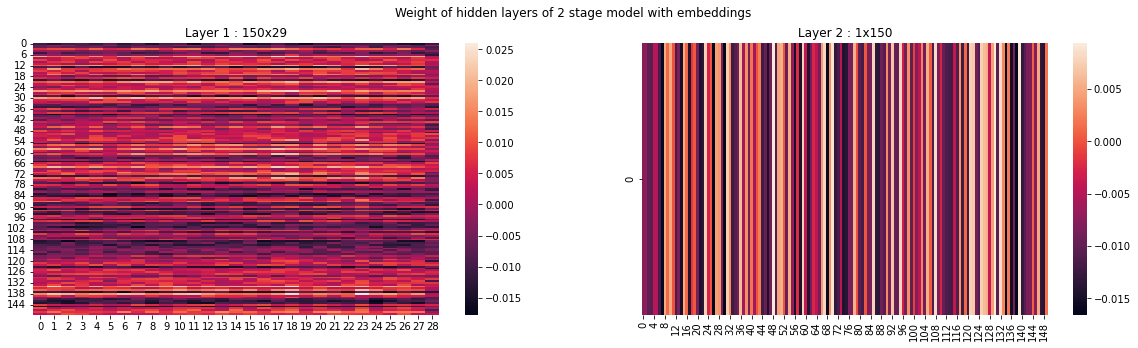

In [69]:
def print_hidden_layers(net, title) : 
    fig,ax = plt.subplots(1 , num_layers, figsize = (20,5))
    plt.suptitle(title)

    for i,ax in enumerate(ax.flat) :
        weights = net[2*i].weight.detach().cpu().numpy()
        sns.heatmap(weights, ax=ax)
        ax.set_title(f'Layer {i + 1} : {weights.shape[0]}x{weights.shape[1]}')
        
print_hidden_layers(net_df, 'Weight of hidden layers of decision-based model with embeddings')
print_hidden_layers(net_2s, 'Weight of hidden layers of 2 stage model with embeddings')

#### Comparison between output of model and labels

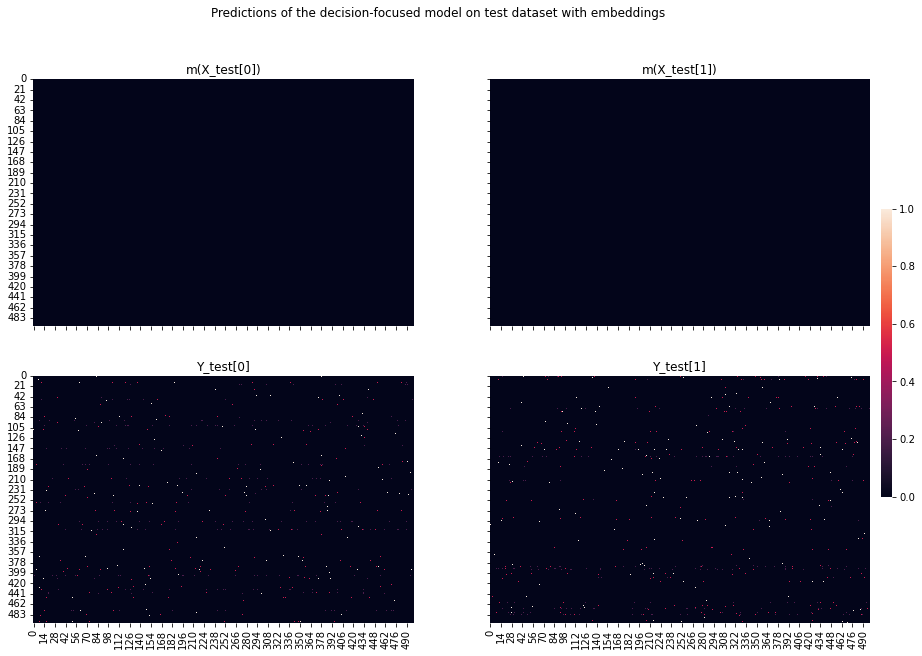

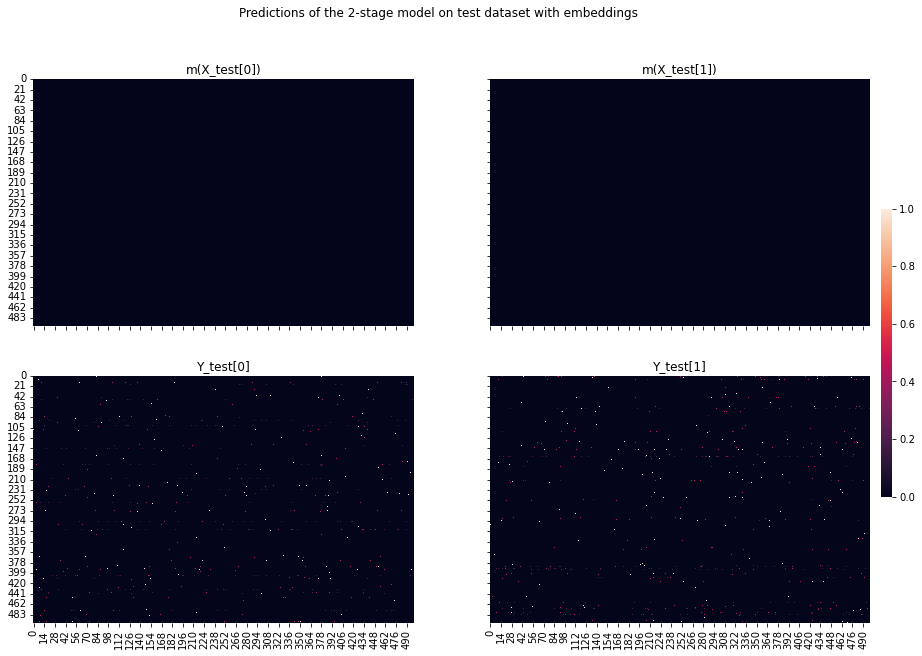

In [70]:
def print_output_test(net, title) :
    fig,ax = plt.subplots(2, 2, figsize = (15,10),sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .01, .4])
    #netcpu = copy.deepcopy(net).to('cpu')
    plt.suptitle(title)
    for i,ax in enumerate(ax.flat) :
        if i < 2 : 
            sns.heatmap(net(X_test[i].to(device)).view_as(Y_test[0]).detach().cpu(), 
                        ax=ax, 
                        vmax = 1, 
                        vmin = 0, 
                        cbar_ax = None if i else cbar_ax,
                        cbar=(i==0))
            ax.set_title(f'm(X_test[{i}])')
        else : 
            sns.heatmap(Y_test[i-2], 
                        ax=ax, 
                        vmax = 1, 
                        vmin = 0, 
                        cbar_ax = None if i else cbar_ax,
                        cbar=(i==0))
            ax.set_title(f'Y_test[{i-2}]')

print_output_test(net_df, "Predictions of the decision-focused model on test dataset with embeddings")
print_output_test(net_2s, "Predictions of the 2-stage model on test dataset with embeddings")

#### Comparison of influence between models and random and greedy

In [ ]:
def compare_grd(net,X,Y) : 
    pred = eval_grd(net, X,Y)
    X, Y = X.to(device), Y.to(device)
    th = np.mean([greedy(k, Y[i,:,:].to(device),w)[0].item() for i in range(X.shape[0])])
    del(X)
    del(Y)
    print(f"The model predicts maximum influence {pred}")
    print(f"The theoretical maximum influence is {th}")
    
print("Decision_based on train dataset : ")
compare_grd(net_df, X_train, Y_train)
print("\n Decision_based on test dataset : ")
compare_grd(net_df, X_test, Y_test)
print("2-stage on train dataset : ")
compare_grd(net_2s, X_train, Y_train)
print("\n 2-stage on test dataset : ")
compare_grd(net_2s, X_test, Y_test)

In [ ]:
greedy_train = np.mean([greedy(k, Y_train[i,:,:].to(device),w)[0].item() for i in range(Y_train.shape[0])])
greedy_test = np.mean([greedy(k, Y_test[i,:,:].to(device),w)[0].item() for i in range(Y_test.shape[0])])

def compare_score_model(train_scores_df, test_scores_df, train_scores_2s, test_scores_2s, title="", rd_score_xtrain=0, rd_score_xtest=0):
    fig,ax = plt.subplots(1,2, figsize = (15,7), sharey=True)
    n = min(len(test_scores_2s),len(test_scores_df))

    ax[0].plot(train_scores_df[:n], label='decision-based')# ax = ax[0])
    ax[0].plot(train_scores_2s[:n], label='2-stage')# ax = ax[0])
    ax[0].hlines(y=rd_score_xtrain, xmin=0, xmax=n, linestyle='--', color='red', label='average random')
    ax[0].hlines(y=greedy_train, xmin=0, xmax=n, linestyle='--', color='green', label='greedy')
    ax[0].legend(loc='upper right')
    ax[0].set_title("Influence on train dataset")
    ax[0].set_ylabel('Average number of targets influenced')
    ax[0].set_xlabel('epochs')

    ax[1].plot(test_scores_df[:n],label='decision-based')
    ax[1].plot(test_scores_2s[:n], label='2-stage')
    ax[1].hlines(y=rd_score_xtest, xmin=0, xmax=n, linestyle='--', color='red', label='average random')
    ax[1].hlines(y=greedy_test, xmin=0, xmax=n, linestyle='--', color='green', label='greedy')
    ax[1].legend(loc='upper right')
    ax[1].set_title("Influence on test dataset")
    ax[1].set_xlabel('epochs')

    fig.suptitle(title)
    plt.show()

compare_score_model(train_scores_df,test_scores_df, train_scores_2s, test_scores_2s, "Models with embeddings", rd_score_xtrain, rd_score_xtest, )


end